# Case Study 05

# Imports

## PyTorch Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

## Other Imports

In [2]:
import datetime
import requests
import os
import random
import shutil
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score

# Datasets

In [3]:
data_acq = {
    "./Module 5/training1.zip": "https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/training1.zip",
    "./Module 5/training2.zip": "https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/training2.zip",
    "./Module 5/holdout.zip": "https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/holdout.zip",
    "./Module 5/mini_holdout.zip": "https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/mini_holdout.zip",
    "./Module 5/mini_holdout_answers.csv": "https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/mini_holdout_answers.csv"
}

extraction_dir = "./Module 5/uncompressed/"
training_dir = "./Module 5/uncompressed/training/"
trn1_dir = "./Module 5/uncompressed/training1/"
trn2_dir = "./Module 5/uncompressed/training2/"

## Download Datasets

In [6]:
def get_data(url, path):
    resp = requests.get(url)
    if resp.status_code == 200:
        with open(path, 'wb') as file:
            file.write(resp.content)
        print(f"File downloaded and saved to {path}")
    else:
        print(f"Failed to download file. HTTP status code: {resp.status_code}")

for key, value in data_acq.items():
    if os.path.exists(key):
        print(f"File already exists: {key}")
    else:
        print(f"Fetching {value}")
        get_data(value, key)
        

File already exists: ./Module 5/training1.zip
File already exists: ./Module 5/training2.zip
File already exists: ./Module 5/holdout.zip
File already exists: ./Module 5/mini_holdout.zip
File already exists: ./Module 5/mini_holdout_answers.csv


## Cleaning Up and Preparation

In [ ]:
print(f"Unzipping Files...")

if os.path.exists(extraction_dir):
    shutil.rmtree(extraction_dir)

os.makedirs(extraction_dir)

for key, value in data_acq.items():
    if zipfile.is_zipfile(key):
        print(f"Extracting {key}")
        with zipfile.ZipFile(key, 'r') as zip_ref:
            zip_ref.extractall(extraction_dir)

Unzipping Files...
Extracting ./Module 5/training1.zip
Extracting ./Module 5/training2.zip
Extracting ./Module 5/holdout.zip
Extracting ./Module 5/mini_holdout.zip
Extracting ./Module 5/mini_holdout_answers.csv


In [ ]:
def merge_fold(src_folder, dest_folder):
    for item in os.listdir(src_folder):
        source_item = os.path.join(src_folder, item)
        dest_item = os.path.join(dest_folder, item)

        if os.path.isdir(source_item):
            shutil.move(source_item, dest_item)
        else:
            shutil.move(source_item, dest_item)

    os.rmdir(src_folder)

print(f"Merging the training data...")

if not os.path.exists(trn1_dir) or not os.path.exists(trn2_dir):
    print(f"Uncompressed data is missing!")
else:
    if os.path.exists(training_dir):
        shutil.rmtree(training_dir)

    os.makedirs(training_dir)
    merge_fold(trn1_dir, training_dir)
    merge_fold(trn2_dir, training_dir)
    print(f"Merging complete!")


Merging the training data...
Uncompressed data is missing!


## Dataset Evaluation

In [4]:
target_names = ['Speed_20', 'Speed_30', 'Speed_50', 'Speed_60', 'Speed_70',
               'Speed_80','Speed_Limit_Ends', 'Speed_100', 'Speed_120', 'Overtaking_Prohibited',
               'Overtakeing_Prohibited_Trucks', 'Priority', 'Priority_Road_Ahead', 'Yield', 'STOP',
               'Entry_Forbidden', 'Trucks_Forbidden', 'No_Entry(one-way traffic)', 'General Danger(!)', 'Left_Curve_Ahead',
               'Right_Curve_Ahead', 'Double_Curve', 'Poor_Surface_Ahead', 'Slippery_Surface_Ahead', 'Road_Narrows_On_Right',
               'Roadwork_Ahead', 'Traffic_Light_Ahead', 'Warning_Pedestrians', 'Warning_Children', 'Warning_Bikes',
               'Ice_Snow', 'Deer_Crossing', 'End_Previous_Limitation', 'Turning_Right_Compulsory', 'Turning_Left_Compulsory',
               'Ahead_Only', 'Straight_Or_Right_Mandatory', 'Straight_Or_Left_Mandatory', 'Passing_Right_Compulsory', 'Passing_Left_Compulsory',
               'Roundabout', 'End_Overtaking_Prohibition', 'End_Overtaking_Prohibition_Trucks']

In [5]:
tg_df = pd.DataFrame(target_names)

In [12]:
tg_df.tail(25)

,0
18,General Danger(!)
19,Left_Curve_Ahead
20,Right_Curve_Ahead
21,Double_Curve
22,Poor_Surface_Ahead
23,Slippery_Surface_Ahead
24,Road_Narrows_On_Right
25,Roadwork_Ahead
26,Traffic_Light_Ahead
27,Warning_Pedestrians


In [38]:
img_sz = (100, 100)

train_datagen = ImageDataGenerator(
        rescale=1./255,
        # rotation_range=40, # Consider Removing
        # width_shift_range=0.1, # Consider Removing
        # height_shift_range=0.1, # Consider Removing
        # zoom_range=0.1, # Consider Removing
        validation_split=.2
        )
validation_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=.2
        )

train_generator = train_datagen.flow_from_directory(
        training_dir,
        target_size = img_sz,
        subset="training",
        batch_size=32,
        class_mode='sparse',
        seed=42,shuffle=True)
validation_generator = validation_datagen.flow_from_directory(
        training_dir,
        target_size=img_sz,
        batch_size=32,
        class_mode='sparse',
        subset="validation",
        seed=42)

Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.


In [ ]:
# View 9 images and their class labels
plt.figure(figsize=(10, 10))
images, labels = next(train_generator)
batch_size = images.shape[0]

for i in range(min(9, batch_size)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow((images[i] * 255).astype("uint8"))
    plt.title(int(labels[i]))
    plt.axis("off")

plt.show()

## Data Augmentation

In [ ]:
# Problematic

# data_augment = tf.keras.Sequential([
#     layers.RandomRotation(0.1),
#     layers.RandomTranslation(0.1, 0.1),
#     layers.RandomZoom(0.1, 0.1)
# ])

# augmented_train = train_generator.map(
#     lambda x, y: (data_augment(x, training=True), y)
# )

# Model

## Normal Model Set Up

In [39]:
model_norm = models.Sequential()
model_norm.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)))
# model.add(layers.MaxPooling2D((2, 2)))
model_norm.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_norm.add(layers.MaxPooling2D((2, 2)))
model_norm.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_norm.add(layers.MaxPooling2D((2, 2)))
model_norm.add(layers.Conv2D(256, (3, 3), activation='relu'))
model_norm.add(layers.Flatten())
model_norm.add(layers.Dense(64, activation='relu'))
model_norm.add(layers.Dense(43))
model_norm.summary()

# model = models.Sequential()
# model.add(layers.Conv2D(32, (3, 3), activation='relu'))
# # model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(256, (3, 3), activation='relu'))
# model.add(layers.Flatten())
# model.add(layers.Dense(64, activation='relu'))
# model.add(layers.Dense(43))
# model.summary()

C:\Program Files\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_41 (Conv2D)              │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 96, 96, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 46, 46, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 23, 23, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 21, 21, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 112896)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │     7,225,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 43)             │         2,795 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,616,619 (29.06 MB)

 Trainable params: 7,616,619 (29.06 MB)

 Non-trainable params: 0 (0.00 B)

## Resnet Model Set Up

In [7]:
def resnet_block(x, filters, stride=1, downsample=False):
    shortcut = x
    # First convolution
    x = layers.Conv2D(filters, kernel_size=3, strides=stride, padding='same',
                      kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    # Second convolution
    x = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same',
                      kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)

    # Adjust shortcut if dimensions change
    if downsample:
        shortcut = layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same',
                                 kernel_initializer='he_normal')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

def build_resnet32(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Rescale input pixels
    x = layers.Rescaling(1./255)(inputs)

    # Initial convolution: 3x3, 16 filters
    x = layers.Conv2D(16, kernel_size=3, strides=1, padding='same',
                      kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Group 1: 5 residual blocks, 16 filters
    for i in range(5):
        x = resnet_block(x, filters=16, stride=1, downsample=False)

    # Group 2: 5 residual blocks, 32 filters (first block downsamples)
    x = resnet_block(x, filters=32, stride=2, downsample=True)
    for i in range(4):
        x = resnet_block(x, filters=32, stride=1, downsample=False)

    # Group 3: 5 residual blocks, 64 filters (first block downsamples)
    x = resnet_block(x, filters=64, stride=2, downsample=True)
    for i in range(4):
        x = resnet_block(x, filters=64, stride=1, downsample=False)

    # Global average pooling and classification layer
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

# -------------------- 6. BUILD THE RESNET-32 MODEL --------------------
input_shape = img_sz + (3,)
num_classes = len(target_names)
model_res = build_resnet32(input_shape, num_classes)

In [ ]:
# model_res.summary()

## Training

In [40]:
def f1_score_it(y_true, y_pred):
    epsilon = tf.keras.backend.epsilon()
    
    # Convert y_true and y_pred to float32 to avoid issues with integer division
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # Calculate Precision and Recall
    precision = tf.reduce_mean(tf.keras.metrics.Precision()(y_true, y_pred))
    recall = tf.reduce_mean(tf.keras.metrics.Recall()(y_true, y_pred))

    # Calculate F1 Score: 2 * (precision * recall) / (precision + recall)
    f1 = 2 * (precision * recall) / (precision + recall + epsilon)
    return f1

In [41]:
# resnet is broken right now
norm_or_res = 0
if (norm_or_res == 1):
    model_norm = model_res

In [42]:
opt = keras.optimizers.Adam()
model_norm.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [63]:
checkpoints = './Module 5/checkpoint.weights.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoints,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history = model_norm.fit(
    train_generator,
    steps_per_epoch=120,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[model_checkpoint_callback],
    initial_epoch=0)

Epoch 1/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 24s 196ms/step - accuracy: 0.9953 - loss: 0.0202 - val_accuracy: 0.9285 - val_loss: 0.3784
Epoch 2/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 23s 191ms/step - accuracy: 0.9955 - loss: 0.0133 - val_accuracy: 0.8890 - val_loss: 0.5553
Epoch 3/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 22s 188ms/step - accuracy: 0.9937 - loss: 0.0197 - val_accuracy: 0.9350 - val_loss: 0.4412
Epoch 4/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 24s 200ms/step - accuracy: 0.9946 - loss: 0.0197 - val_accuracy: 0.9314 - val_loss: 0.3731
Epoch 5/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 24s 198ms/step - accuracy: 0.9965 - loss: 0.0103 - val_accuracy: 0.9203 - val_loss: 0.3499
Epoch 6/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 23s 195ms/step - accuracy: 0.9956 - loss: 0.0104 - val_accuracy: 0.9267 - val_loss: 0.4858
Epoch 7/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 23s 192ms/step - accuracy: 0.9953 - loss: 0.0203 - val_accuracy: 0.9314 - val_loss: 0.3920
Epoch 8/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 23s 195ms/step - accuracy: 0.9962 - loss: 0

C:\Program Files\Python312\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


120/120 ━━━━━━━━━━━━━━━━━━━━ 11s 92ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.9333 - val_loss: 0.3952
Epoch 10/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 23s 195ms/step - accuracy: 0.9998 - loss: 0.0030 - val_accuracy: 0.9223 - val_loss: 0.4087
Epoch 11/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 23s 192ms/step - accuracy: 0.9975 - loss: 0.0090 - val_accuracy: 0.9154 - val_loss: 0.5519
Epoch 12/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 23s 191ms/step - accuracy: 0.9933 - loss: 0.0248 - val_accuracy: 0.9283 - val_loss: 0.3817
Epoch 13/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 23s 196ms/step - accuracy: 0.9969 - loss: 0.0121 - val_accuracy: 0.9232 - val_loss: 0.3895
Epoch 14/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 23s 192ms/step - accuracy: 0.9973 - loss: 0.0071 - val_accuracy: 0.9046 - val_loss: 0.6821
Epoch 15/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 23s 189ms/step - accuracy: 0.9835 - loss: 0.0692 - val_accuracy: 0.9171 - val_loss: 0.4897
Epoch 16/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 23s 191ms/step - accuracy: 0.9901 - loss: 0.0340

# Model Testing and Predictions

In [64]:
test_dir = './Module 5/uncompressed/'

test_datagen = ImageDataGenerator(rescale=1./255)

## Testing against the Mini Holdout

In [65]:

test_generator_mini = test_datagen.flow_from_directory(
    test_dir,
    classes=['mini_holdout'],
    target_size=img_sz,
    class_mode='sparse',
    shuffle=False)
probs_mini = model_norm.predict(test_generator_mini)
preds_mini = [np.argmax(probas) for probas in probs_mini]

# The prediction times are whats important. This is how fast the model can understand the image that it is given. In the case of driving too mnay seconds equals wreck or forget the sign.

Found 201 images belonging to 1 classes.
3/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

C:\Program Files\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


In [66]:
mini_ans = pd.read_csv("./Module 5/mini_holdout_answers.csv")
mini_ans['Sign'] = mini_ans['ClassId'].map(lambda x: target_names[x])

In [67]:
preds_df = pd.DataFrame(preds_mini, columns=['ClassId'])
preds_df['Sign'] = preds_df['ClassId'].map(lambda x: target_names[x])

In [ ]:
display(mini_ans.head(5))
display(preds_df.head(5))

In [68]:
print(classification_report(mini_ans['Sign'], preds_df['Sign']))

                               precision    recall  f1-score   support

                   Ahead_Only       1.00      0.75      0.86         4
                Deer_Crossing       0.50      1.00      0.67         1
                 Double_Curve       0.67      0.67      0.67         3
   End_Overtaking_Prohibition       1.00      0.50      0.67         2
      End_Previous_Limitation       1.00      1.00      1.00         1
              Entry_Forbidden       1.00      1.00      1.00         2
            General Danger(!)       0.80      1.00      0.89         8
                     Ice_Snow       1.00      0.50      0.67         4
             Left_Curve_Ahead       0.00      0.00      0.00         0
    No_Entry(one-way traffic)       1.00      1.00      1.00         7
Overtakeing_Prohibited_Trucks       1.00      1.00      1.00        12
        Overtaking_Prohibited       0.91      1.00      0.95        10
     Passing_Right_Compulsory       1.00      1.00      1.00         9
     

C:\Program Files\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Program Files\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Program Files\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Confusion Matrix

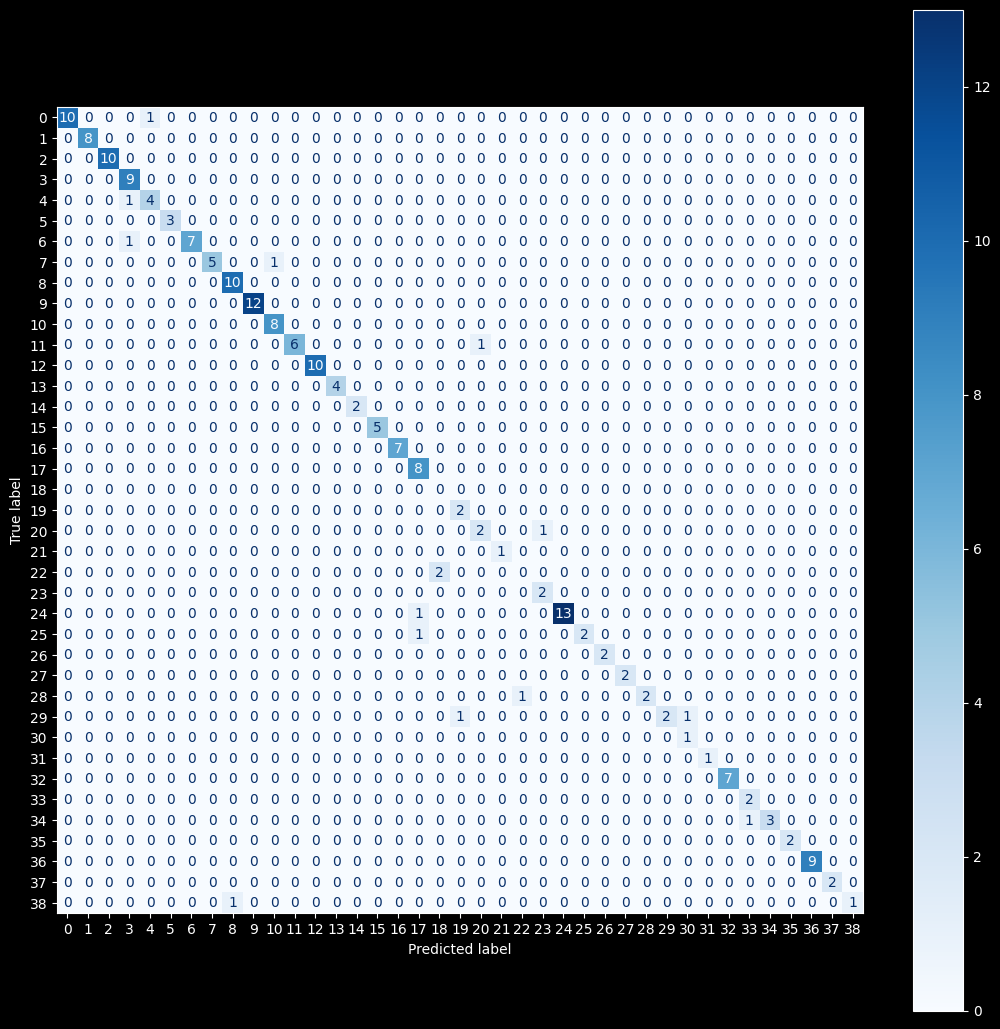

In [69]:
cm = confusion_matrix(mini_ans['ClassId'], preds_df['ClassId'])
cmd = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(13,13))
cmd.plot(ax=ax, cmap="Blues", values_format='.5g')

In [ ]:
res_mini_df = pd.DataFrame()
res_mini_df['MiniPred'] = preds_df['ClassId']
res_mini_df['MiniActual'] = mini_ans['ClassId']

class_mini_accuracies = []
class_mini_f1_scores = []

for i in range(43):
    class_indices = np.where(mini_ans['ClassId'] == i)[0]

    y_true_class = y_true[class_indices]
    y_pred_class = y_pred_classes[class_indices]

    class_accuracy = accuracy_score(y_true_class, y_pred_class)
    class_f1 = f1_score(y_true_class, y_pred_class, average='weighted')

    class_mini_accuracies.append(class_accuracy)
    class_mini_f1_scores.append(class_f1)

res_mini_melted = res_mini_df.melt(id_vars='Class', value_vars=['Accuracy', 'F1 Score'], var_name='Metric', value_name='Score')

plt.figure(figsize=(10, 8))
sns.barplot(x='Class', y='Score', hue='Metric', data=res_mini_melted)
plt.title('Accuracy and F1 Scores per Sign')
plt.xlabel('Sign')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.show()

,MiniPred,MiniActual
0,16,16
1,1,1
2,38,38
3,33,33
4,11,11


In [73]:
len(np.where(res_mini_df['MiniActual'] == 0)[0])

0

In [33]:
# May be necessary to avoid issues with states
validation_generator.reset() 

In [60]:
y_pred = model_norm.predict(validation_generator, steps=int(np.ceil(validation_generator.samples / validation_generator.batch_size)), verbose=1)
y_true = validation_generator.classes

y_pred_classes = np.argmax(y_pred, axis=1)
class_accuracies = []
class_f1_scores = []

for i in range(43):
    class_indices = np.where(y_true == i)[0]

    y_true_class = y_true[class_indices]
    y_pred_class = y_pred_classes[class_indices]

    class_accuracy = accuracy_score(y_true_class, y_pred_class)
    class_f1 = f1_score(y_true_class, y_pred_class, average='weighted')

    class_accuracies.append(class_accuracy)
    class_f1_scores.append(class_f1)

246/246 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step


In [61]:
# classes = [f'Class {i}' for i in range(43)]
data = {
    'Class': target_names,
    'Accuracy': class_accuracies,
    'F1 Score': class_f1_scores
}

res_df = pd.DataFrame(data)

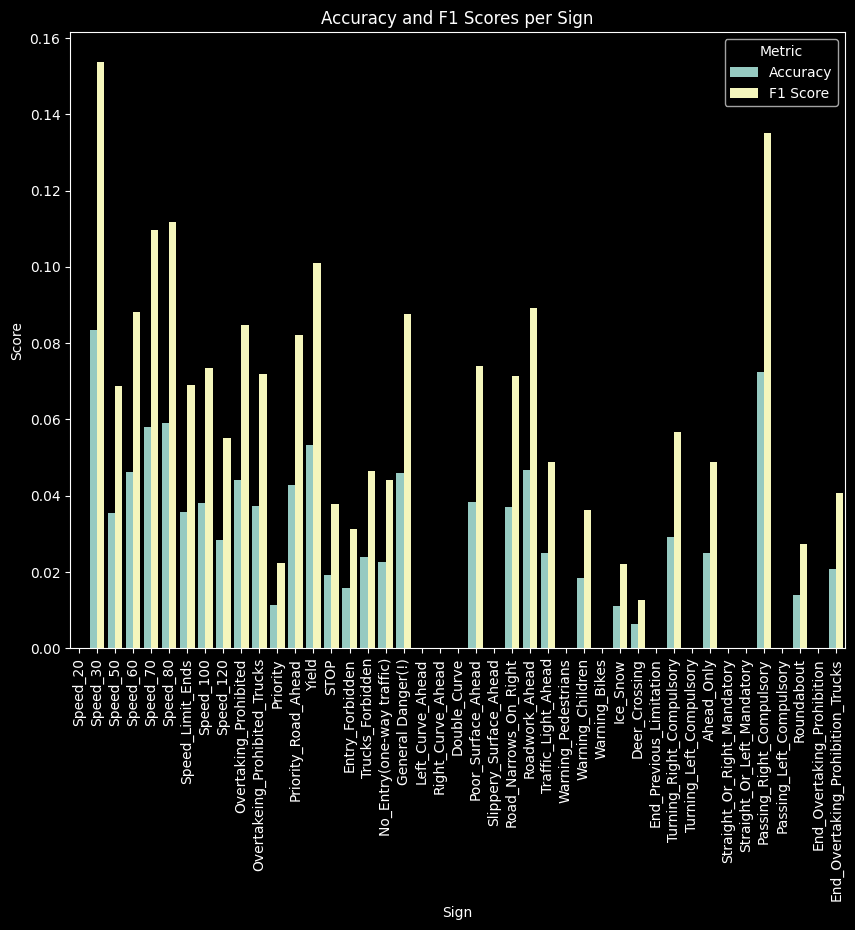

In [62]:
res_melted = res_df.melt(id_vars='Class', value_vars=['Accuracy', 'F1 Score'], var_name='Metric', value_name='Score')

plt.figure(figsize=(10, 8))
sns.barplot(x='Class', y='Score', hue='Metric', data=res_melted)
plt.title('Accuracy and F1 Scores per Sign')
plt.xlabel('Sign')
plt.ylabel('Score')
plt.xticks(rotation=90)
plt.show()

## Predicting Against the Holdout

In [ ]:
test_generator_hold = test_datagen.flow_from_directory(
    test_dir,
    classes=['holdout'],
    target_size=img_sz,
    class_mode='sparse',
    shuffle=False)

probs_hold = model_norm.predict(test_generator_hold)
preds_hold = [np.argmax(probas) for probas in probs_hold]

Found 12630 images belonging to 1 classes.
  1/395 ━━━━━━━━━━━━━━━━━━━━ 28s 71ms/step

C:\Program Files\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


395/395 ━━━━━━━━━━━━━━━━━━━━ 88s 222ms/step
